The aim of this notebook is to predict the likelihoo of the risk of accident (continuous value between 0 and 1) in several roads (a row is equal to a road).
We can say that this is a regression problem, because we are predicting a continuous value. 

According to Wikipedia: "If it can take on two real values and all the values between them, the variable is continuous in that interval."

We are going to test different models and then predict on the one that perform the best on train data. 
I will iteratively change the notebook after each submission to see if I can improve the scores of the models, by either adding Cross validation to obtain optimal parameters, improving data transformation etc...

Below are the submission scores (mean-squared-error) Version 01:
1. 0.05990

The score of Version 02:
2. 0.05663 


### Import Librairies

In [26]:
import pandas as pd 
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
import logging 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder

##### Set the Logger 

In [51]:
logging.basicConfig(encoding='utf-8', 
                    level=logging.INFO,
                   )

logger = logging.getLogger(__name__)

### Load Data 

In [2]:

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


In [74]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")

ids = test_df.id

### We will perform a simple EDA.

In [4]:
train_df.head(5)

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [5]:
train_df.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


There's no null values, so we do not need to worry about this.

In [6]:
train_df.isnull().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

In [8]:
numerical_attributes = ["float64", "int64"]
NUMERICAL_COLUMNS = [col for col in train_df if train_df[col].dtypes in numerical_attributes]
CATEGORICAL_COLUMNS = list(set(train_df.columns) - set(NUMERICAL_COLUMNS))

There's not a lot of classes for the categorical variables, so we'll just use one hot encoding.

In [9]:
for col in train_df[CATEGORICAL_COLUMNS].columns:
    print(f"Col Name: {col}")
    print(f"Number of unique values : {train_df[col].nunique()}")


Col Name: time_of_day
Number of unique values : 3
Col Name: road_signs_present
Number of unique values : 2
Col Name: lighting
Number of unique values : 3
Col Name: weather
Number of unique values : 3
Col Name: school_season
Number of unique values : 2
Col Name: public_road
Number of unique values : 2
Col Name: road_type
Number of unique values : 3
Col Name: holiday
Number of unique values : 2


#### Distribution of numerical values.
We have two continuous values and the rest are categorical.

The `num_lanes` and `speed_limit`have a uniform distribution which means that there'll be 
- less bias toward one category 
- model will be able to learn from all categories  

However the `num_of_reported_accidents` is pretty skewed.

The curvature and accidents are not normally distributed which means several things:
- Descriptive stats :	Mean and standard deviation may not fully represent the data; median may be more informative
- Parametric tests :	Tests like t-test, ANOVA assume normality → results may be invalid
- Regression / ML :	Algorithms that assume Gaussian errors (like linear regression) may have biased estimates
- Transformations :	Sometimes log, sqrt, or Box-Cox transforms can make data closer to normal

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

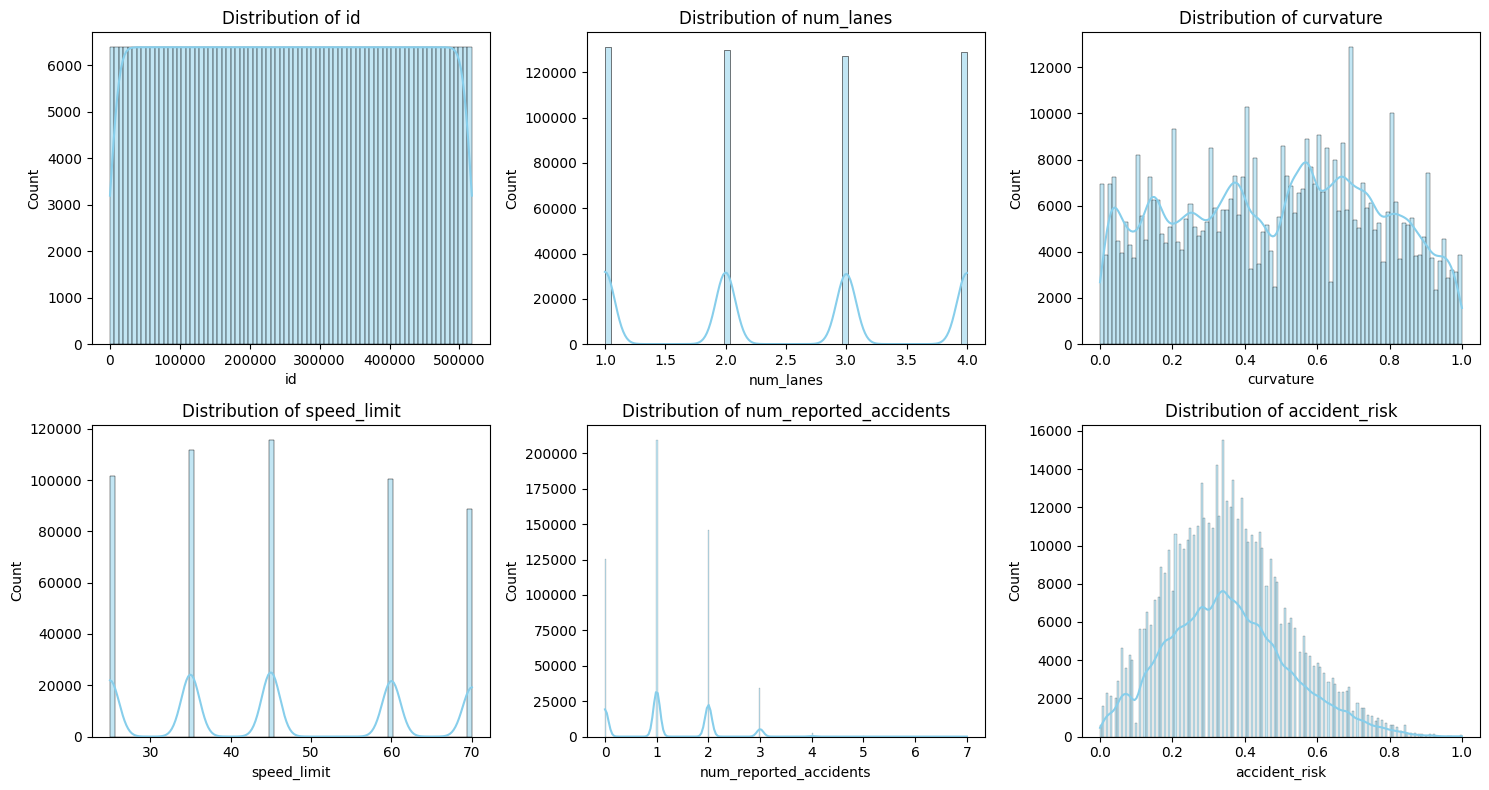

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten() 

for ax, col in zip(axes, NUMERICAL_COLUMNS):
    sns.histplot(train_df[col], kde=True, ax=ax, color='skyblue')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()


Accidents Risk is definitly not distruted normally.

In [11]:
from scipy.stats import shapiro
stat, p = shapiro(train_df['accident_risk'])
if p > 0.05:
    print("Fail to reject H0 → data likely normal")
else:
    print("Reject H0 → data not normal")


Reject H0 → data not normal


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 517754.
  res = hypotest_fun_out(*samples, **kwds)


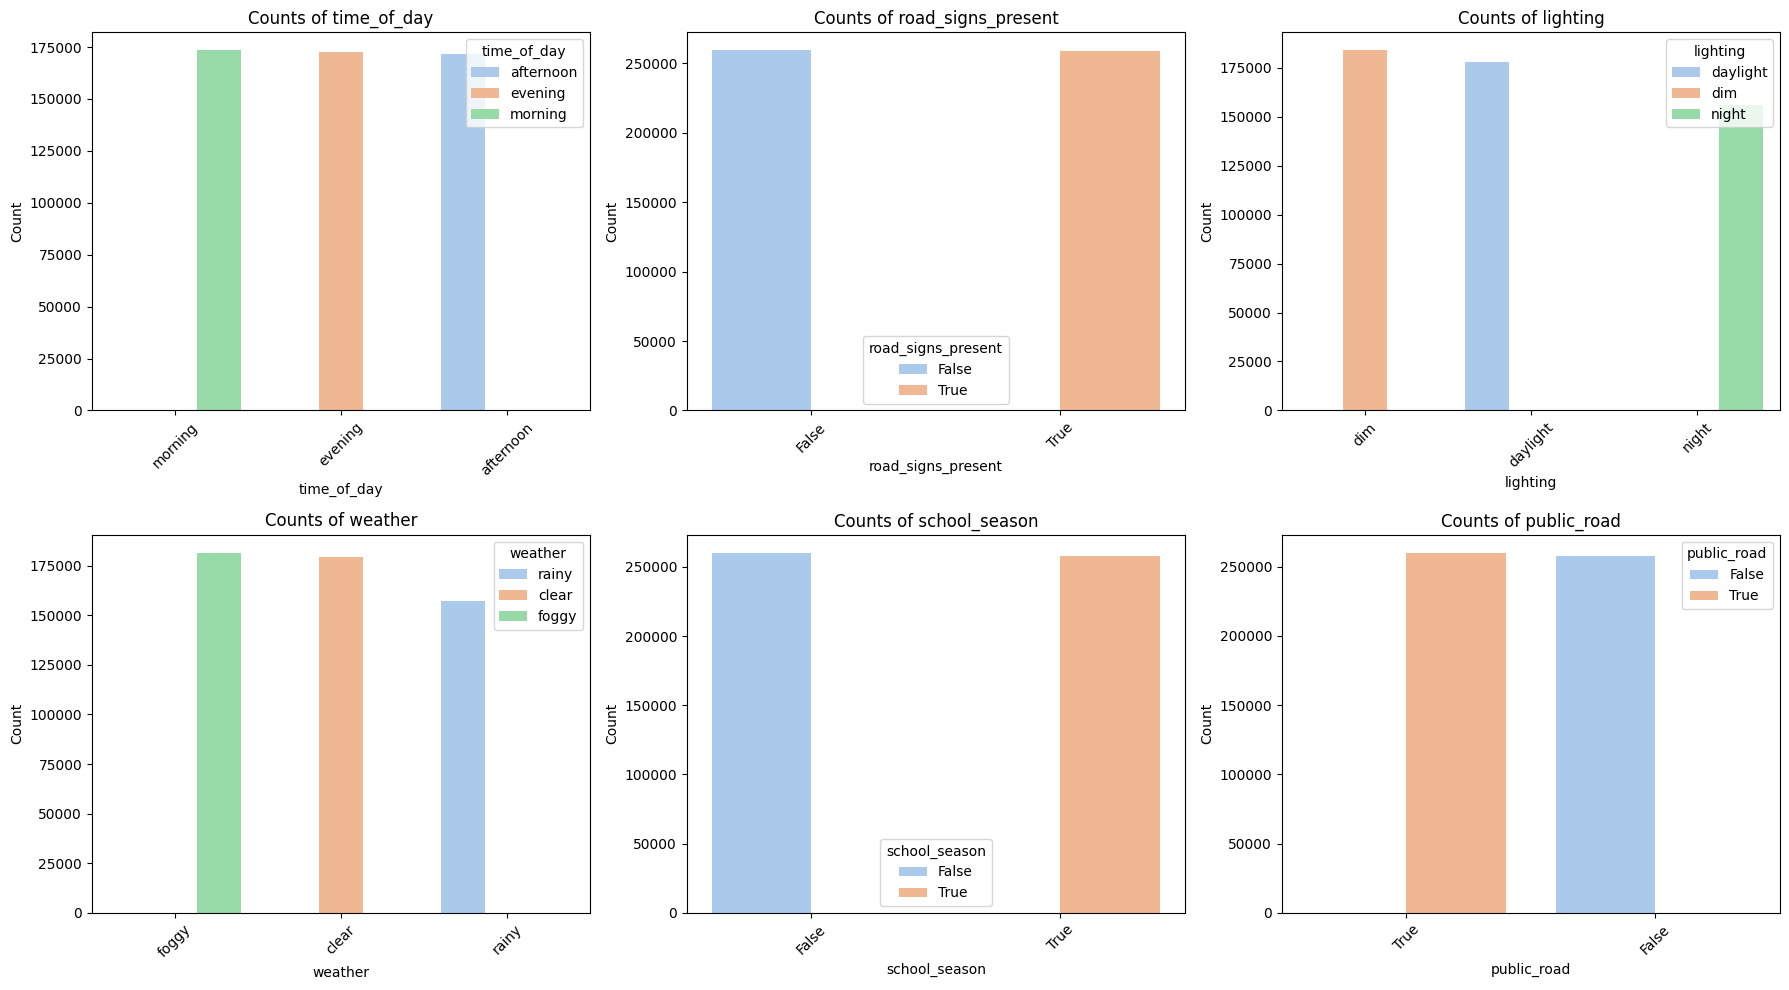

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # flatten to 1D array for easy iteration

for ax, col in zip(axes, CATEGORICAL_COLUMNS):
    sns.countplot(x=col, data=train_df, ax=ax, palette='pastel', order=train_df[col].value_counts().index, hue=col)
    ax.set_title(f'Counts of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Data Transformation Pipeline.

In [27]:
def apply_transformation_pipeline(df: pd.DataFrame, preprocessor=None, is_test: bool=False):
    """
    If is_test=False: fits transformer and splits into train/valid sets.
    If is_test=True: applies fitted transformer to test data.

    Returns:
        - Train mode: X_train, X_valid, y_train, y_valid, preprocessor
        - Test mode: X_test_transformed
    """
    bool_cols = df.select_dtypes(include=['bool']).columns
    df[bool_cols] = df[bool_cols].astype(int)

    if is_test:
        if preprocessor is None:
            raise ValueError("You must provide a fitted preprocessor when is_test=True")

        X_test_transformed = preprocessor.transform(df)
        return X_test_transformed

    y = df["accident_risk"]
    X = df.drop(columns=["accident_risk"])

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.7, random_state=0
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), make_column_selector(dtype_include=['int64', 'float64'])),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
             make_column_selector(dtype_include=['object', 'category', 'bool']))
        ]
    )

    preprocessor.fit(X_train)
    X_train_transformed = preprocessor.transform(X_train)
    X_valid_transformed = preprocessor.transform(X_valid)

    return X_train_transformed, X_valid_transformed, y_train, y_valid, preprocessor


In [53]:
X_train, X_valid, y_train, y_valid, preprocessor = apply_transformation_pipeline(train_df)


### Let's start the prediction pipeline.
For that we are going to initialize a Base model that will basic function for all other models.
In this notebook, we're going to see three different model :

- **Linear Regression:**  
A simple, interpretable model that assumes a straight-line relationship between features and the target. It finds the best-fitting line by minimizing the sum of squared errors. Fast to train and works well when relationships are truly linear, but struggles with complex, non-linear patterns. No hyperparameters to tune, making it a good baseline model.  

- **Decision Tree Regressor:**  
A tree-based model that splits the data into branches based on feature values, creating a flowchart-like structure. At each split, it asks a yes/no question about a feature (e.g., "Is age > 30?") and continues until reaching leaf nodes with predictions. Easy to interpret and visualize, handles non-linear relationships well, but tends to overfit on training data if not constrained with parameters like max_depth or min_samples_split.  

- **Random Forest Regressor:**  
An ensemble model that creates multiple decision trees (a "forest") using random subsets of data and features, then averages their predictions. This randomness reduces overfitting and makes it more robust than a single decision tree. Generally performs well out-of-the-box, handles non-linear relationships and feature interactions naturally, but is slower to train and less interpretable than simpler models. Key parameters include n_estimators (number of trees) and max_depth (tree complexity).  

### Trainer Class

This class is used to train the models and cross-validate each of them. 


In [113]:
class ModelTrainer:
    def __init__(self, models):
        self.models = models 
        self.cv_results = {}
        self.trained_models = {}
    
    def cross_validate_all(self, X, y, cv=5):
        """Cross-validate all models and return results"""
        for model in self.models:
            name = model.__class__.__name__
            print(f"Cross-validating: {name}")
            
            scores = cross_validate(
                model, X, y, cv=cv,
                scoring=['neg_mean_squared_error', 'r2']
            )
            
            self.cv_results[name] = {
                "mse": -scores['test_neg_mean_squared_error'].mean(),
                "mse_std": scores['test_neg_mean_squared_error'].std(),
                "r2": scores['test_r2'].mean(),
                "r2_std": scores['test_r2'].std()
            }
        
        return pd.DataFrame(self.cv_results).T
    
    def train_best(self, X, y, metric='r2'):
        """Train the best model on all data after CV"""
        results_df = pd.DataFrame(self.cv_results).T
        best_model_name = results_df[metric].idxmax()
        
        for model in self.models:
            if model.__class__.__name__ == best_model_name:
                print(f"Training best model: {best_model_name}")
                model.fit(X, y)
                self.trained_models[best_model_name] = model
                return model

In [ ]:
# Combine train + valid for cross-validation
X_all = np.vstack([X_train, X_valid])  # or np.concatenate([X_train, X_valid])
y_all = np.concatenate([y_train, y_valid])

The Random Forest is clearly the better model. We're gonna try to improve this one.

In [120]:
from sklearn.model_selection import RandomizedSearchCV 

def find_best_params(model, param_grid, X, y, cv=3):
    """Find best parameters for a single model"""
    grid_search = RandomizedSearchCV(
        model,
        param_grid,
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        n_iter=10
    )

    grid_search.fit(X, y)
    
    print(f"{model.__class__.__name__}:")
    print(f"  Best params: {grid_search.best_params_}")
    print(f"  Best CV R²: {grid_search.best_score_:.3f}\n")
    
    return grid_search.best_params_

# Define parameter grids
rf_params = {
    'n_estimators': [10, 20,30,40, 50],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10]
}

dt_params = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

# Find best parameters
best_rf_params = find_best_params(RandomForestRegressor(random_state=42), rf_params, X_all, y_all)
best_dt_params = find_best_params(DecisionTreeRegressor(random_state=42), dt_params, X_all, y_all)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
RandomForestRegressor:
  Best params: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 10}
  Best CV R²: -0.003

Fitting 3 folds for each of 10 candidates, totalling 30 fits
DecisionTreeRegressor:
  Best params: {'min_samples_split': 5, 'max_depth': 10}
  Best CV R²: -0.003



In [124]:
# models = [LinearRegression(), RandomForestRegressor(**best_rf_params, random_state=42), DecisionTreeRegressor(**best_dt_params, random_state=42)]
models = [LinearRegression(), DecisionTreeRegressor(**best_dt_params, random_state=42), RandomForestRegressor(**best_rf_params, random_state=42)]

trainer = ModelTrainer(models)

# Cross-validate to find best model
cv_results = trainer.cross_validate_all(X_all, y_all, cv=5)
print(cv_results)

# Train best model on all data
best_model = trainer.train_best(X_all, y_all, metric='r2')

Cross-validating: LinearRegression
Cross-validating: DecisionTreeRegressor
Cross-validating: RandomForestRegressor
                            mse   mse_std        r2    r2_std
LinearRegression       0.005402  0.000025  0.804953  0.000914
DecisionTreeRegressor  0.003194  0.000014  0.884667  0.000475
RandomForestRegressor  0.003161  0.000016  0.885853  0.000608
Training best model: RandomForestRegressor


In [126]:
y_validation_prediction = best_model.predict(X_valid)
mse = mean_squared_error(y_valid, y_validation_prediction)
print(f"The Mean squared error for validation data is : {mse}")

The Mean squared error for validation data is : 0.0030928519061293683


In [127]:
X_test = apply_transformation_pipeline(test_df, preprocessor=preprocessor, is_test=True)
y_pred = best_model.predict(X_test)

In [128]:
df_submission = pd.DataFrame({
    'id':ids,
    'accident_risk': y_pred
})


In [129]:
df_submission.to_csv('/kaggle/working/submission_v2.csv', index=False)